# 03_fredf_baseline

Прототип реализации FreDF и сравнение с базовыми моделями.

# Применение моделей на исходных данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 300

from ts_toolkit.io import clean_timeseries
from ts_toolkit.calendar import add_hour_sin_cos
from ts_toolkit.viz import plot_history_forecast
from ts_toolkit.split import three_way_split
from src.models.catboost_delay_model import DelayForecastModel
from ts_toolkit.metrics import daily_mae
from ts_toolkit.metrics import global_metrics

In [2]:
from src.data_loader import fetch_frame
# df = fetch_frame()
df = fetch_frame(
    use_cache=True,
    cache_filename="only_common_delayp90.parquet"
)
print(df.head())

print(df.info())

print(df.describe())

print(df.isnull().sum())


                     common_delay_p90
ts                                   
2025-04-27 18:00:30       2394.210526
2025-04-27 18:00:45       2398.424069
2025-04-27 18:01:00       2396.124524
2025-04-27 18:01:15       2417.008604
2025-04-27 18:01:30       2420.737327
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90643 entries, 2025-04-27 18:00:30 to 2025-05-13 11:41:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   common_delay_p90  90641 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB
None
       common_delay_p90
count      90641.000000
mean        1802.349510
std          901.617551
min          235.000000
25%          922.395833
50%         2094.852941
75%         2382.755633
max         8500.000000
common_delay_p90    2
dtype: int64


In [3]:
df.info()

df.describe()

df.isnull().sum()

df.head()

df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90643 entries, 2025-04-27 18:00:30 to 2025-05-13 11:41:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   common_delay_p90  90641 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


,common_delay_p90
ts,
2025-05-13 11:40:00,3738.866397
2025-05-13 11:40:15,3325.806452
2025-05-13 11:40:30,2479.835391
2025-05-13 11:40:45,2452.444134
2025-05-13 11:41:00,2498.843188


In [4]:
df = clean_timeseries(df, 'common_delay_p90')   # вместо блока 0‑3
# df = add_hour_sin_cos(df)
# feature_cols = ['hour_sin', 'hour_cos']

In [5]:
# feature_cols

# Максимально честный тест

In [6]:
# Разделяем данные
df_train, df_val, df_hold = three_way_split(df, train_ratio=0.8, val_ratio=0.19)

# ── Создание и обучение модели ─────────────────────────────────
model = DelayForecastModel(
    horizon=len(df_hold), # Горизонт прогноза равен размеру hold-out
    lags=[1, 2, 4, 96, 192, 5760],
    roll_windows=[4, 96, 192, 1920, 2880, 4320, 5760, 8640]
)

# Обучаем модель. fit больше не возвращает датафреймы.
print("Начинаю обучение модели...")
model.fit(
    train_df=df_train, 
    target_col='common_delay_p90',
    val_df=df_val
    # feature_cols больше не нужны, модель сама создает календарные признаки
)
print("Модель успешно обучена!")
model.save("my_delay_model_v1") 

Начинаю обучение модели...
Модель успешно обучена!
Model saved to my_delay_model_v1


In [9]:
from src.models.catboost_delay_model import DelayForecastModel

df_train, df_val, df_hold = three_way_split(df, train_ratio=0.8, val_ratio=0.19)
df_context = pd.concat([df_train, df_val])
# Загружаем модель из папки
loaded_model = DelayForecastModel.load("my_delay_model_v2")

# И сразу используем для прогноза
forecast = loaded_model.predict(df_context) 
print(forecast.head())

# Подготавливаем данные для сравнения
pred_idx = forecast.index
y_true = df_hold['common_delay_p90'].reindex(forecast.index).dropna()
y_pred = forecast.reindex(y_true.index).dropna() # Убедимся, что все выровнено

print(f"Длина прогноза: {len(y_pred)}, Длина реальных данных: {len(y_true)}")

2025-05-13 07:54:30    1958.042291
2025-05-13 07:54:45    1956.774803
2025-05-13 07:55:00    1955.457732
2025-05-13 07:55:15    1954.120011
2025-05-13 07:55:30    1953.216633
Freq: 15s, Name: forecast, dtype: float64
Длина прогноза: 907, Длина реальных данных: 907


In [8]:
# ── Прогноз на будущее (hold-out) ──────────────────────────
# Для предсказания нам нужна история, достаточная для создания самых "длинных" признаков
history_need = max(model.lags + model.roll_windows)

# Используем только доступную историю (train + val)
# .tail() не нужен, так как _prepare_features сам разберется
df_context = pd.concat([df_train, df_val])

# 🎯 НОВЫЙ МЕТОД ПРОГНОЗА: один вызов возвращает весь горизонт
print("Делаю прогноз...")
y_pred_series = model.predict(df_hist=df_context)
print("Прогноз готов!")

# Подготавливаем данные для сравнения
pred_idx = y_pred_series.index
y_true = df_hold['common_delay_p90'].reindex(y_pred_series.index).dropna()
y_pred = y_pred_series.reindex(y_true.index).dropna() # Убедимся, что все выровнено

print(f"Длина прогноза: {len(y_pred)}, Длина реальных данных: {len(y_true)}")

Делаю прогноз...
Прогноз готов!
Длина прогноза: 907, Длина реальных данных: 907


<Axes: >

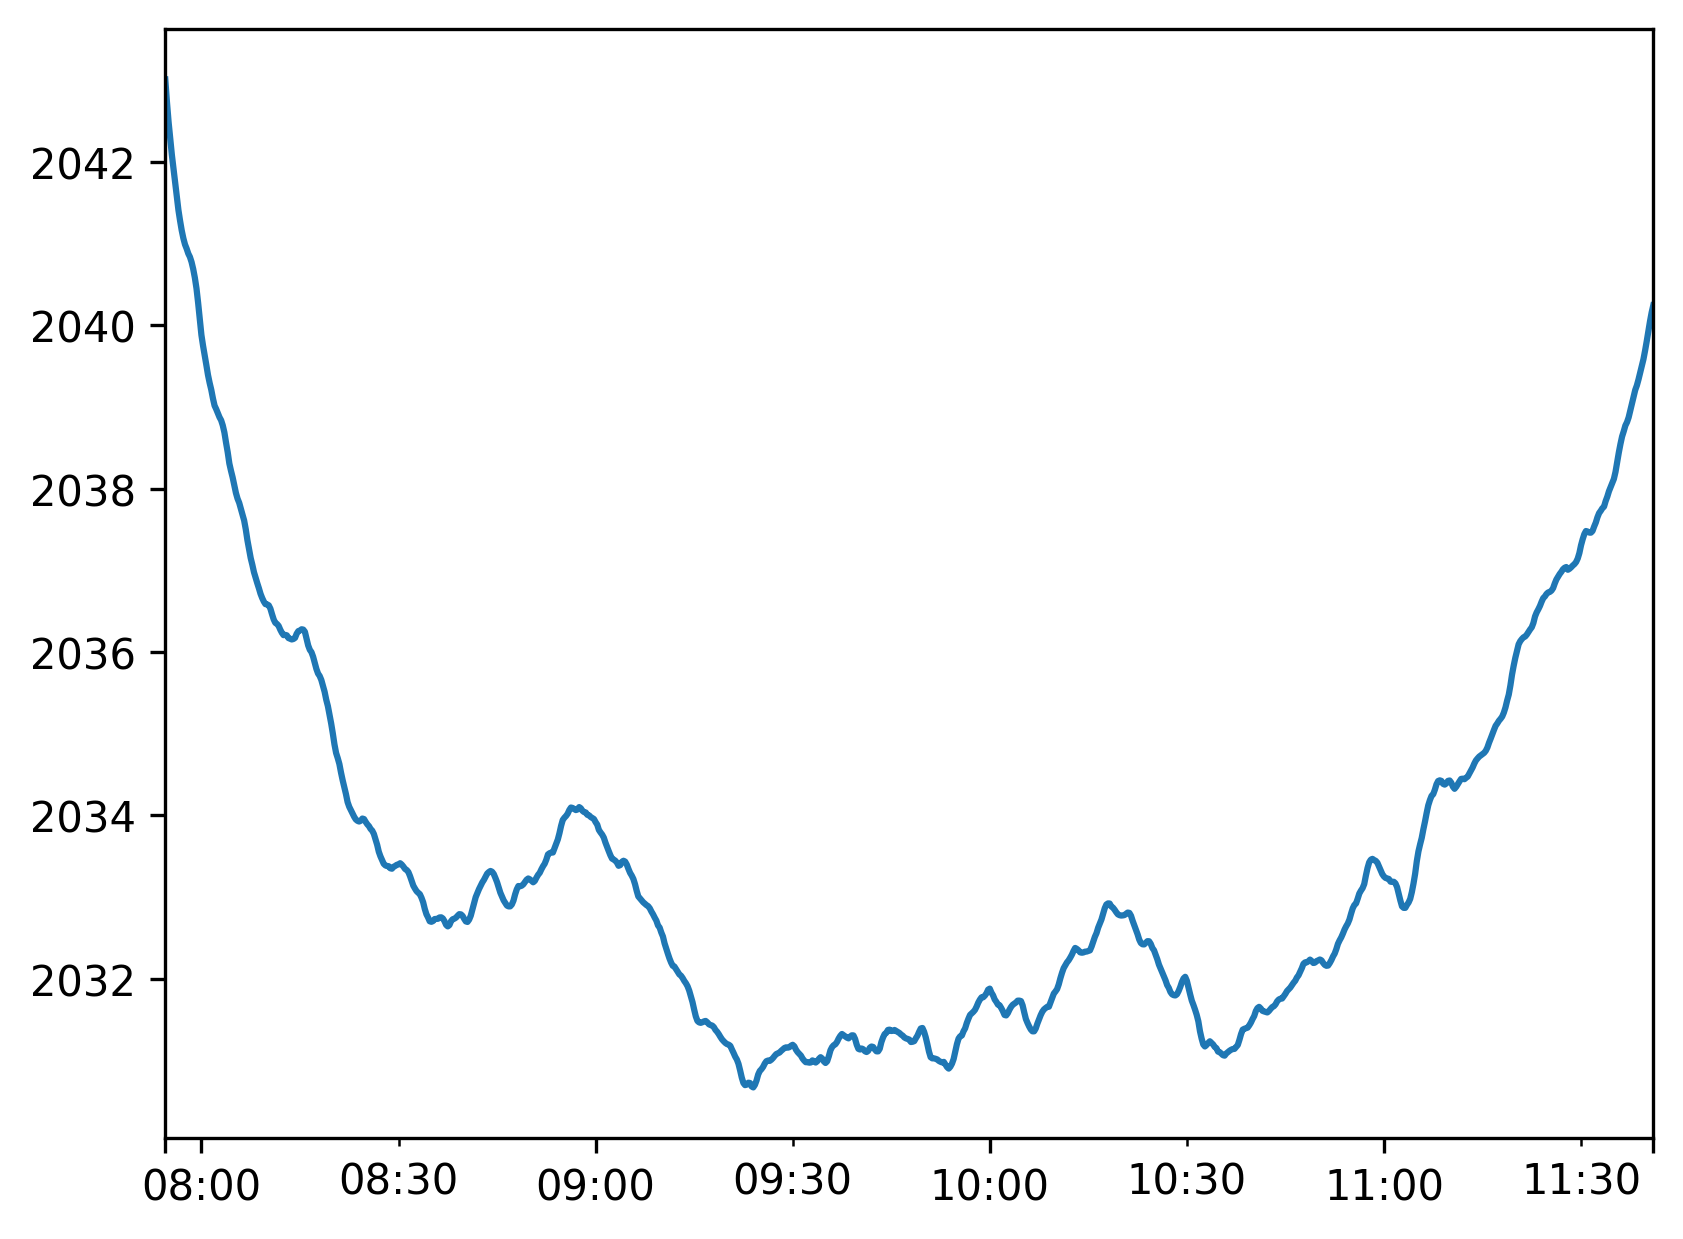

In [9]:
pd.Series(y_pred, index=pred_idx).plot()

<Axes: >

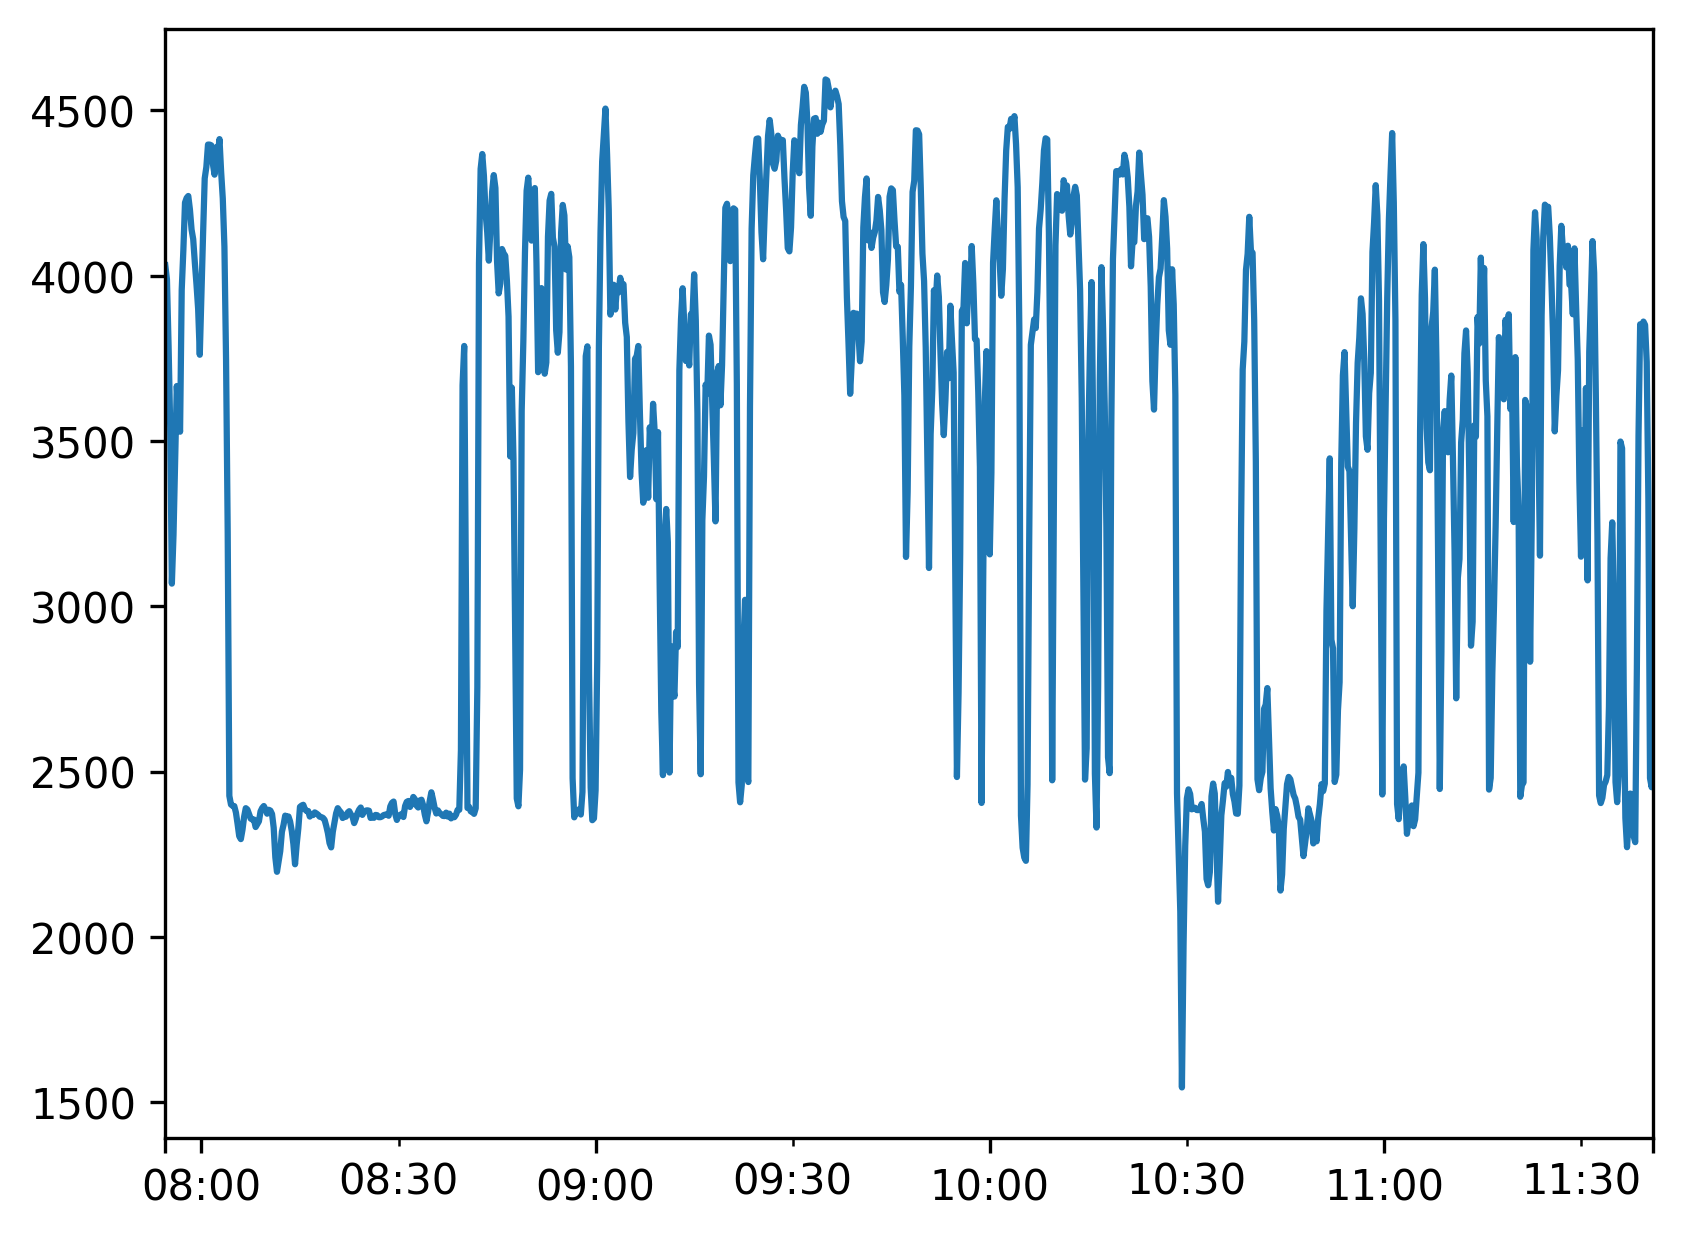

In [10]:
pd.Series(y_true, index=pred_idx).plot()


Blind 24-h test • MAE=1326.7  RMSE=1539.3  MAPE=35.79%  on 907 valid points


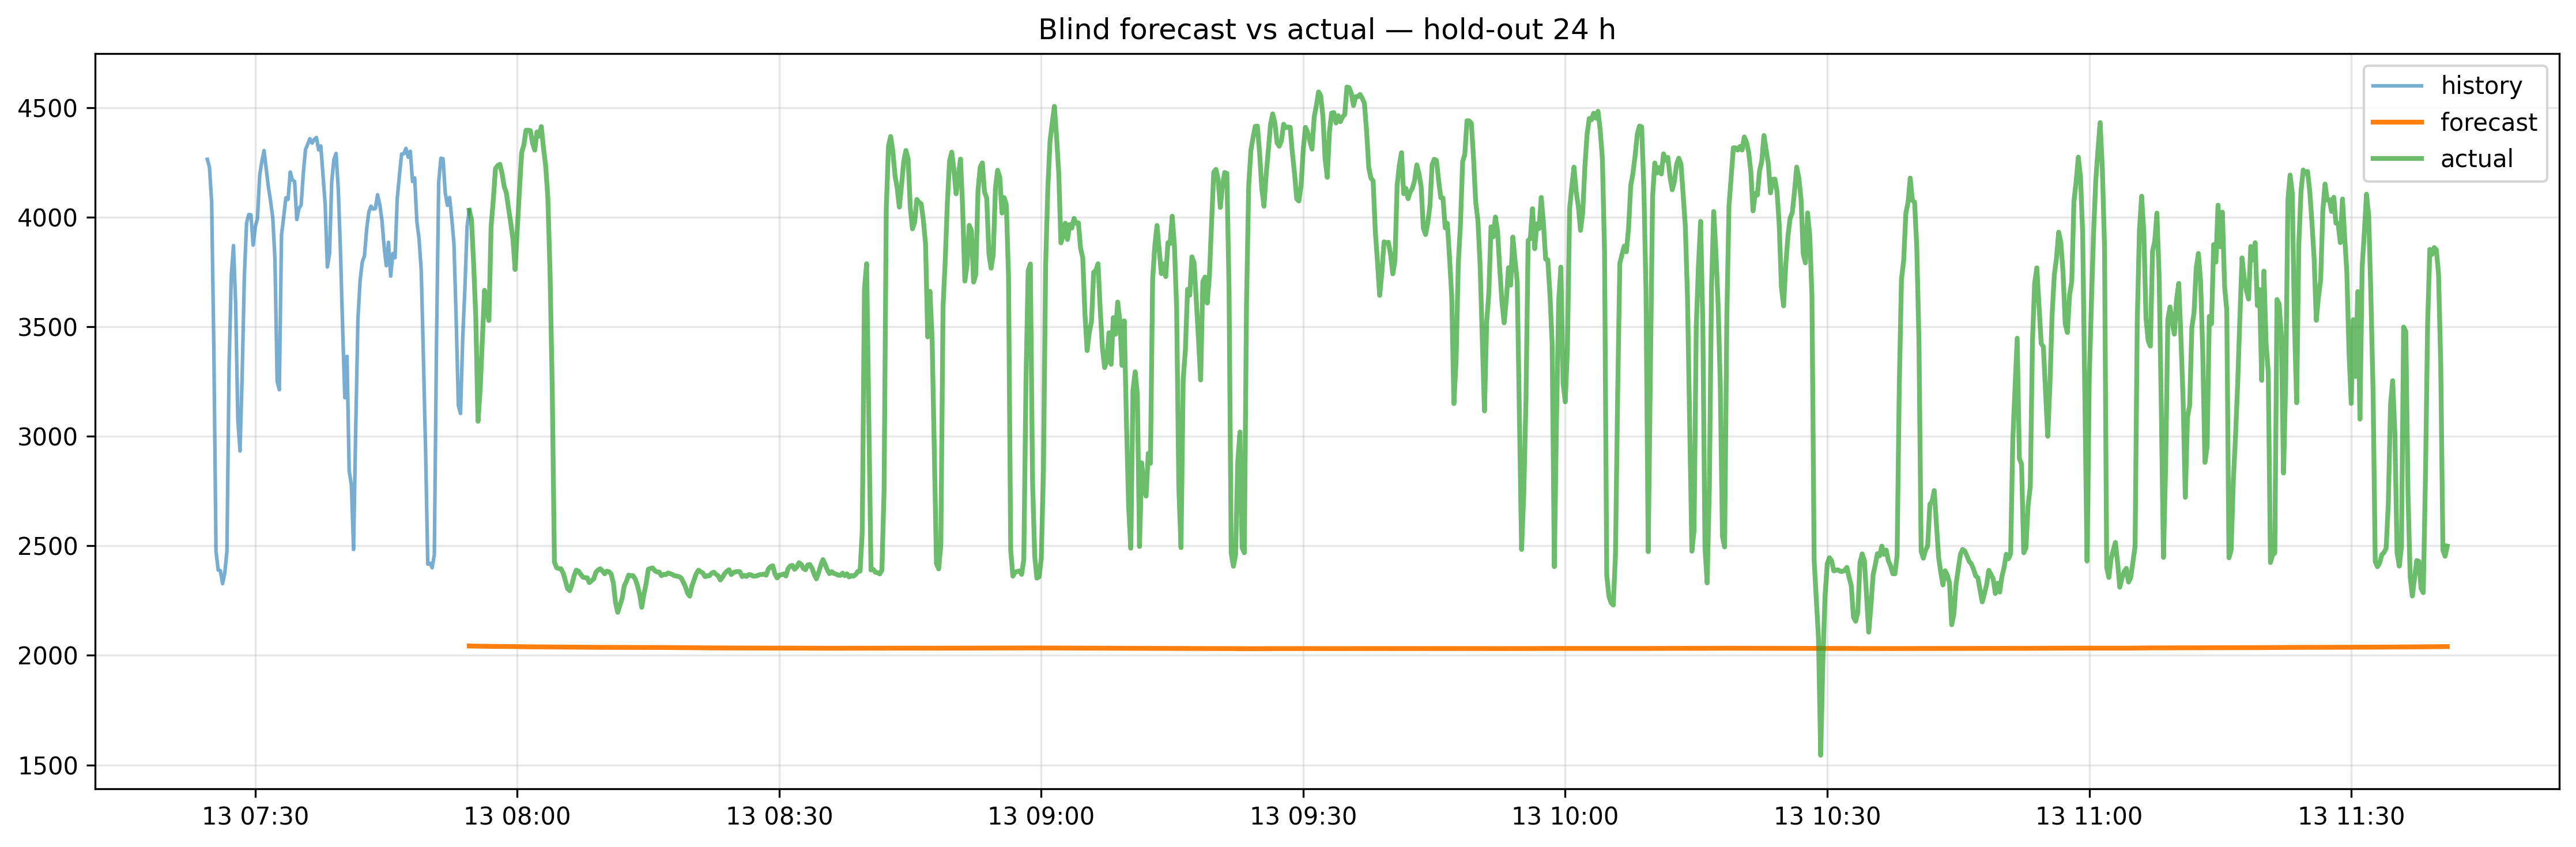

In [11]:
# y_true и y_pred уже созданы в предыдущей ячейке

metrics = global_metrics(y_true, y_pred)
print(f"Blind 24-h test • MAE={metrics['MAE']:.1f}  RMSE={metrics['RMSE']:.1f}  MAPE={metrics['MAPE']:.2f}%  "
      f"on {len(y_true)} valid points")

# ── график: история 3 сут + прогноз vs факт ──
# hist_start = pred_idx[0] - pd.Timedelta(hours=1)
hist_start = pred_idx[0] - pd.Timedelta(minutes=30)
plot_history_forecast(
    history  = df.loc[hist_start:pred_idx[0], 'common_delay_p90'],
    forecast = pd.Series(y_pred, index=pred_idx),
    actual   = y_true,
    title    = 'Blind forecast vs actual — hold-out 24 h'
)

In [14]:
from ts_toolkit.metrics import daily_mae

daily_mae_df = daily_mae(pd.Series(y_true, index=pred_idx), pd.Series(y_pred, index=pred_idx))
print(daily_mae_df)

        index          MAE
0  2025-05-13  1326.717233


In [15]:
# last element of df_train
df_val['common_delay_p90'].tail(1)

ts
2025-05-13 07:54:15    3958.708709
Name: common_delay_p90, dtype: float64

In [16]:
# i want to make list of last element of df_val by len of df_hold

# last element of df_val
last_element_df_val = df_val['common_delay_p90'].tail(1)

# len of df_hold
len_df_hold = len(df_hold)

# make list of last element of df_val by len of df_hold
list_of_last_elements = [float(last_element_df_val.iloc[0])] * len_df_hold

# print list_of_last_elements
# list_of_last_elements

In [17]:
# i want to make list of avg elemet by 15 minutes of concat df_train and df_val

# concat df_train and df_val
df_train_val = pd.concat([df_train, df_val])

# make list of avg elemet of df_train_val
list_of_avg_elements = [float(df_train_val['common_delay_p90'].mean())] * len(df_hold)

# print list_of_avg_elements
# list_of_avg_elements

In [18]:
# i want to make list of avg elements by last 15 minutes of concat df_train and df_val by len of df_hold

# Concatenate df_train and df_val
combined_df = pd.concat([df_train, df_val])

# Get the timestamp for 15 minutes before the last entry in combined_df
last_timestamp = combined_df.index[-1]
time_window_start = last_timestamp - pd.Timedelta(minutes=15)

# Filter data for the last 15 minutes and calculate the average
last_15_min_data = combined_df.loc[time_window_start:last_timestamp, 'common_delay_p90']
avg_last_15_minutes = last_15_min_data.mean()

# Create a list of this average, repeated len_df_hold times
list_of_avg_last_15_minutes_elements = [float(avg_last_15_minutes)] * len(df_hold)

# print list_of_avg_last_15_minutes_elements
# list_of_avg_last_15_minutes_elements



In [19]:
y_true[1]

/tmp/ipykernel_295930/2601156901.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true[1]


np.float64(3989.411764705882)

Blind 24-h test • MAE=758.6  RMSE=985.6  MAPE=28.84%  on 907 valid points


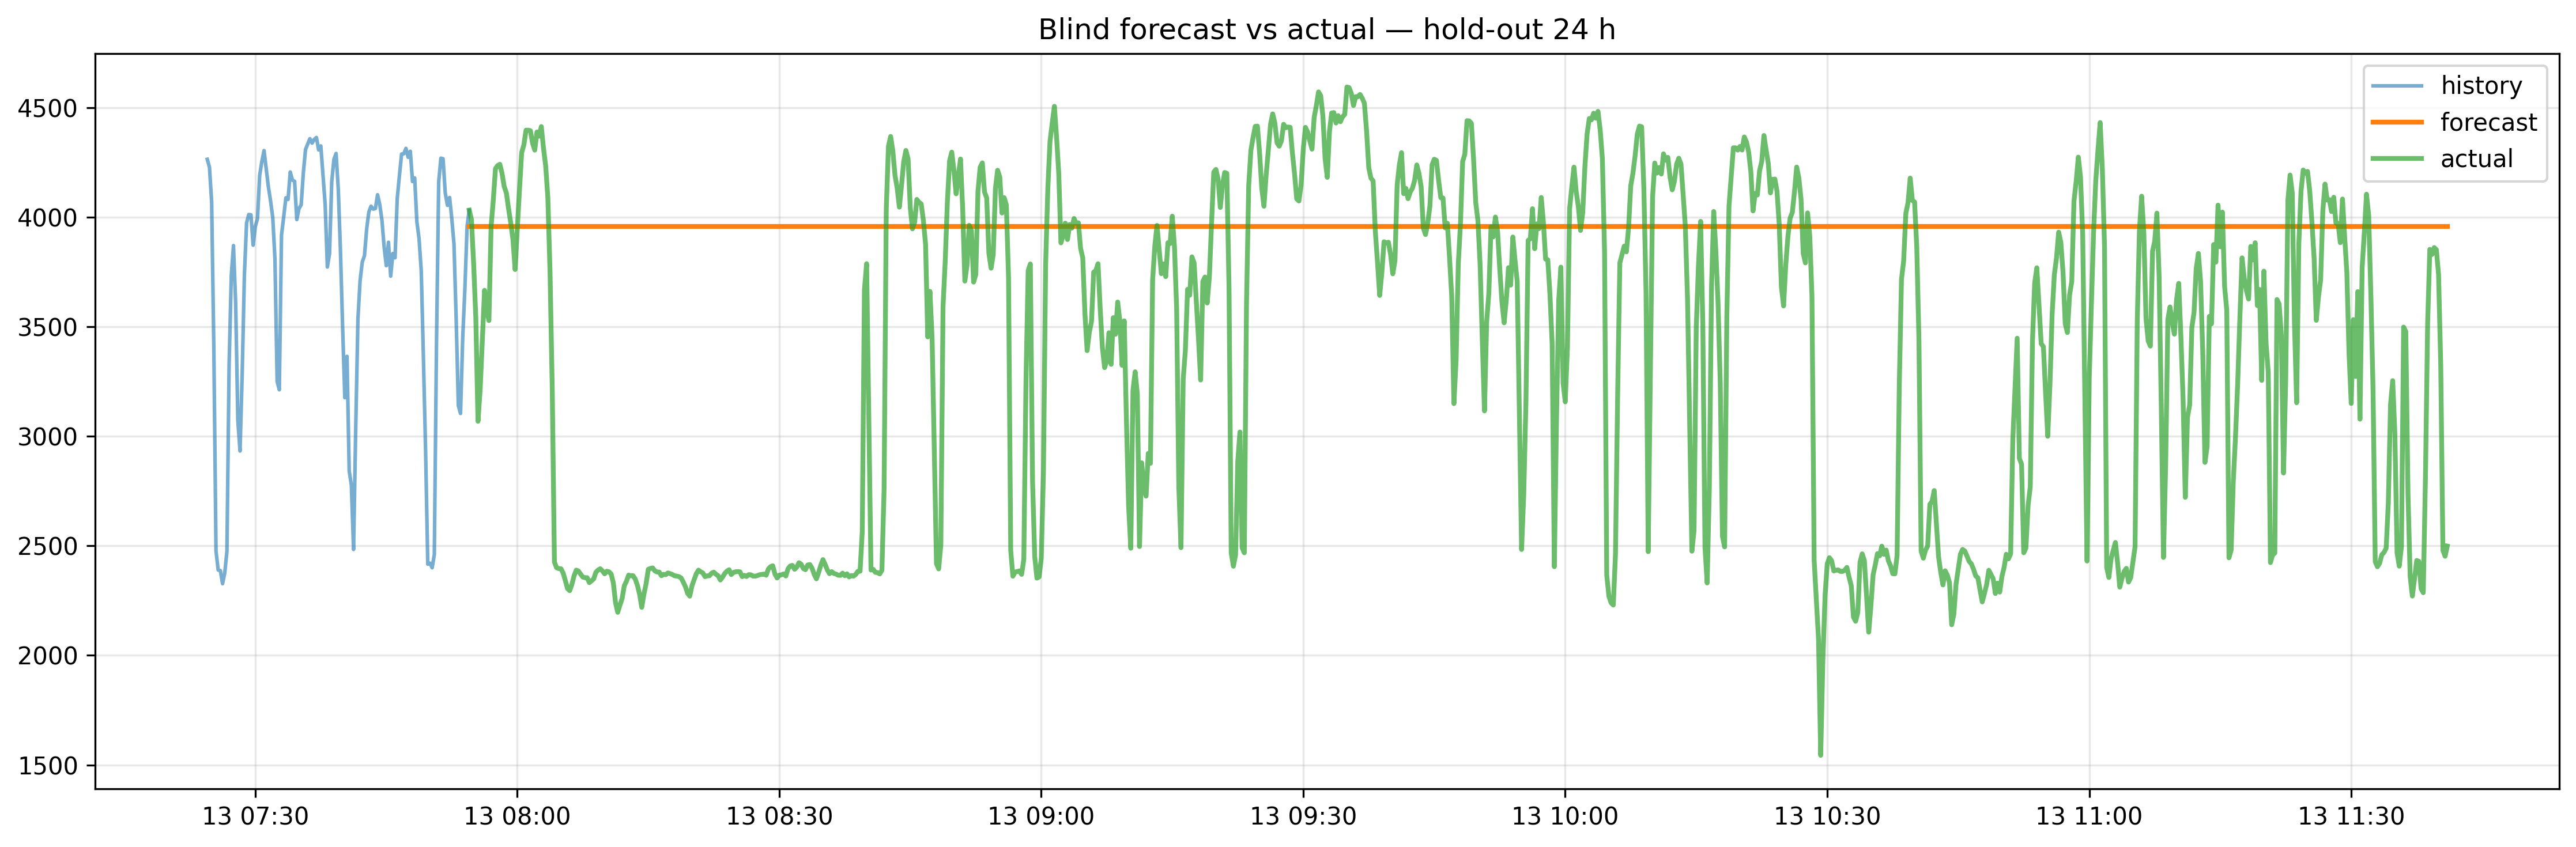

In [20]:
# y_true и y_pred уже созданы в предыдущей ячейке

metrics = global_metrics(y_true, list_of_last_elements)
print(f"Blind 24-h test • MAE={metrics['MAE']:.1f}  RMSE={metrics['RMSE']:.1f}  MAPE={metrics['MAPE']:.2f}%  "
      f"on {len(y_true)} valid points")

# ── график: история 3 сут + прогноз vs факт ──
# hist_start = pred_idx[0] - pd.Timedelta(hours=1)
hist_start = pred_idx[0] - pd.Timedelta(minutes=30)
plot_history_forecast(
    history  = df.loc[hist_start:pred_idx[0], 'common_delay_p90'],
    forecast = pd.Series(list_of_last_elements, index=pred_idx),
    actual   = y_true,
    title    = 'Blind forecast vs actual — hold-out 24 h'
)

Blind 24-h test • MAE=1573.0  RMSE=1756.3  MAPE=43.55%  on 907 valid points


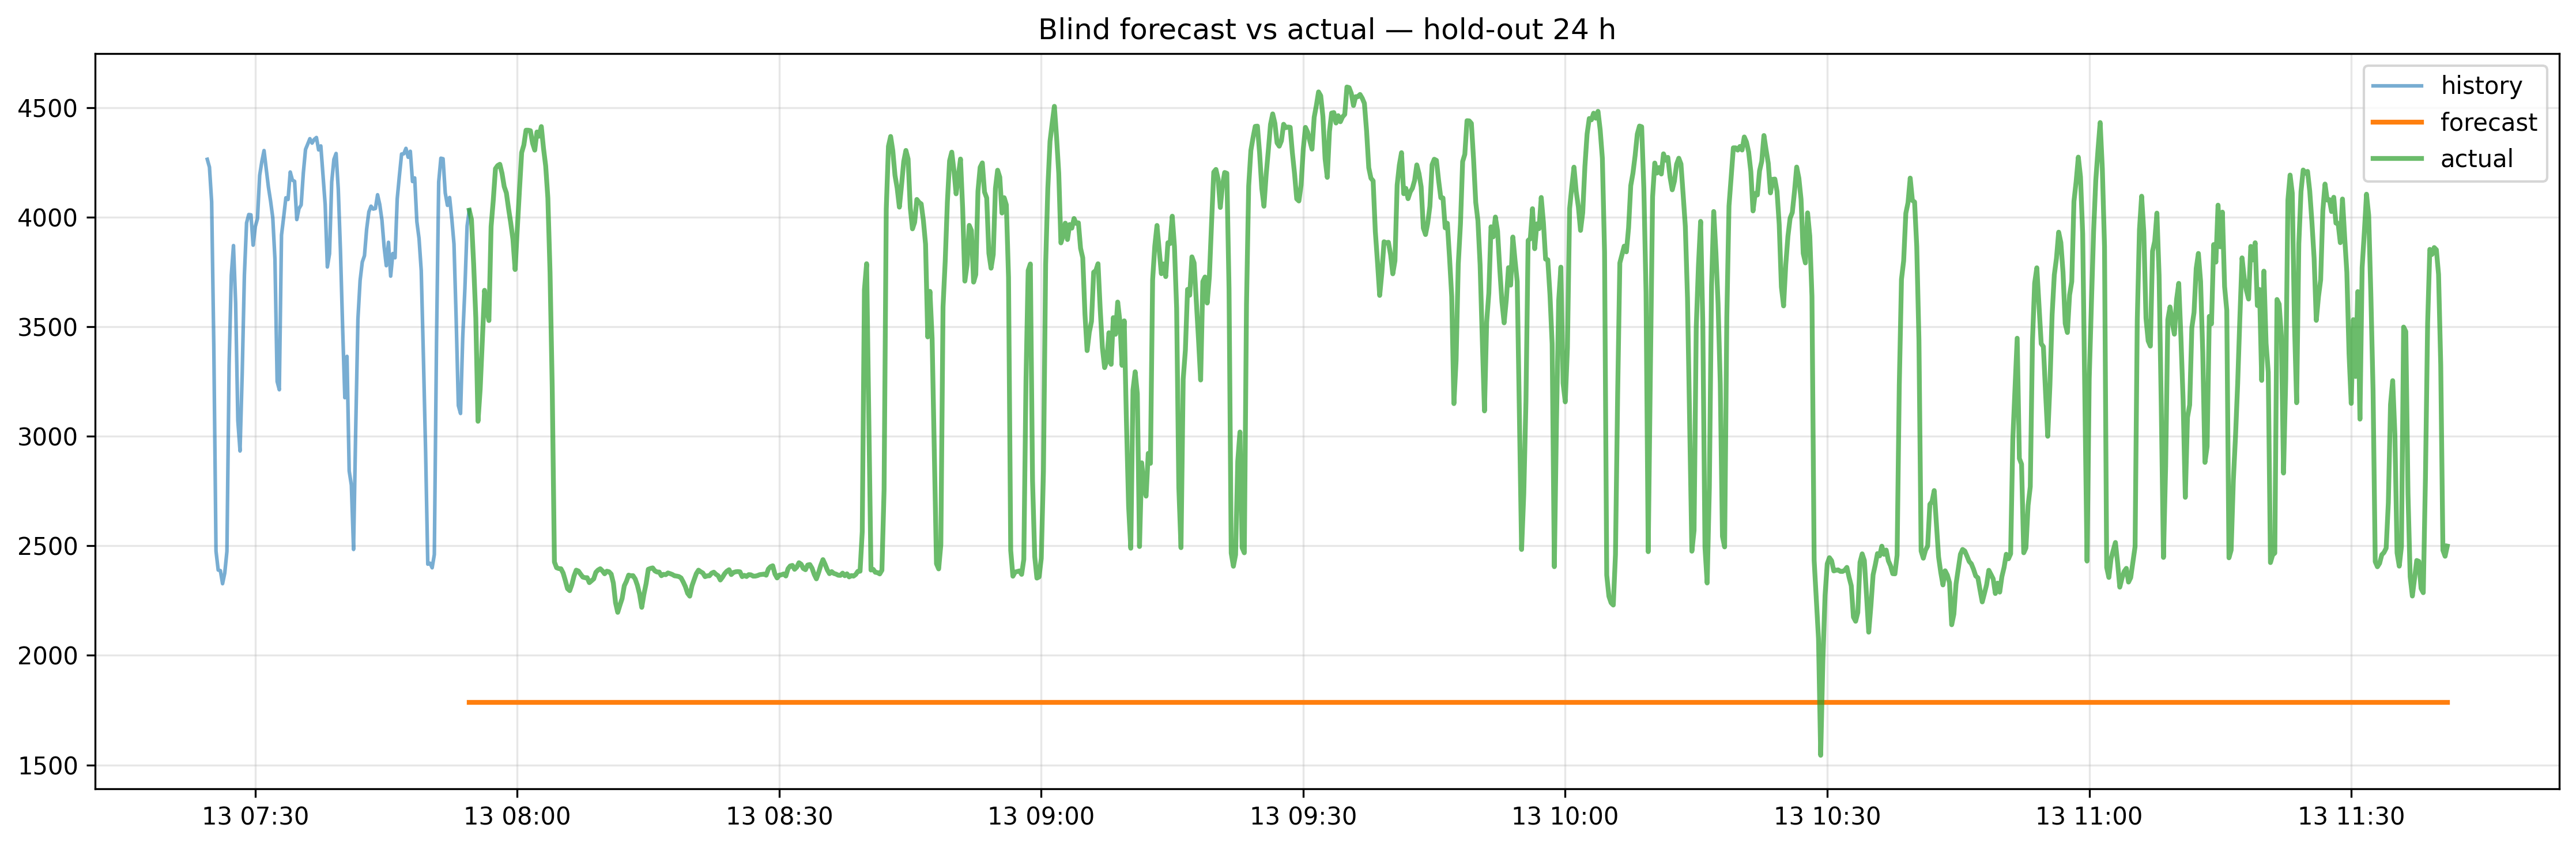

In [21]:
# y_true и y_pred уже созданы в предыдущей ячейке

metrics = global_metrics(y_true, list_of_avg_elements)
print(f"Blind 24-h test • MAE={metrics['MAE']:.1f}  RMSE={metrics['RMSE']:.1f}  MAPE={metrics['MAPE']:.2f}%  "
      f"on {len(y_true)} valid points")

# ── график: история 3 сут + прогноз vs факт ──
# hist_start = pred_idx[0] - pd.Timedelta(hours=1)
hist_start = pred_idx[0] - pd.Timedelta(minutes=30)
plot_history_forecast(
    history  = df.loc[hist_start:pred_idx[0], 'common_delay_p90'],
    forecast = pd.Series(list_of_avg_elements, index=pred_idx),
    actual   = y_true,
    title    = 'Blind forecast vs actual — hold-out 24 h'
)

Blind 24-h test • MAE=700.3  RMSE=857.1  MAPE=25.57%  on 907 valid points


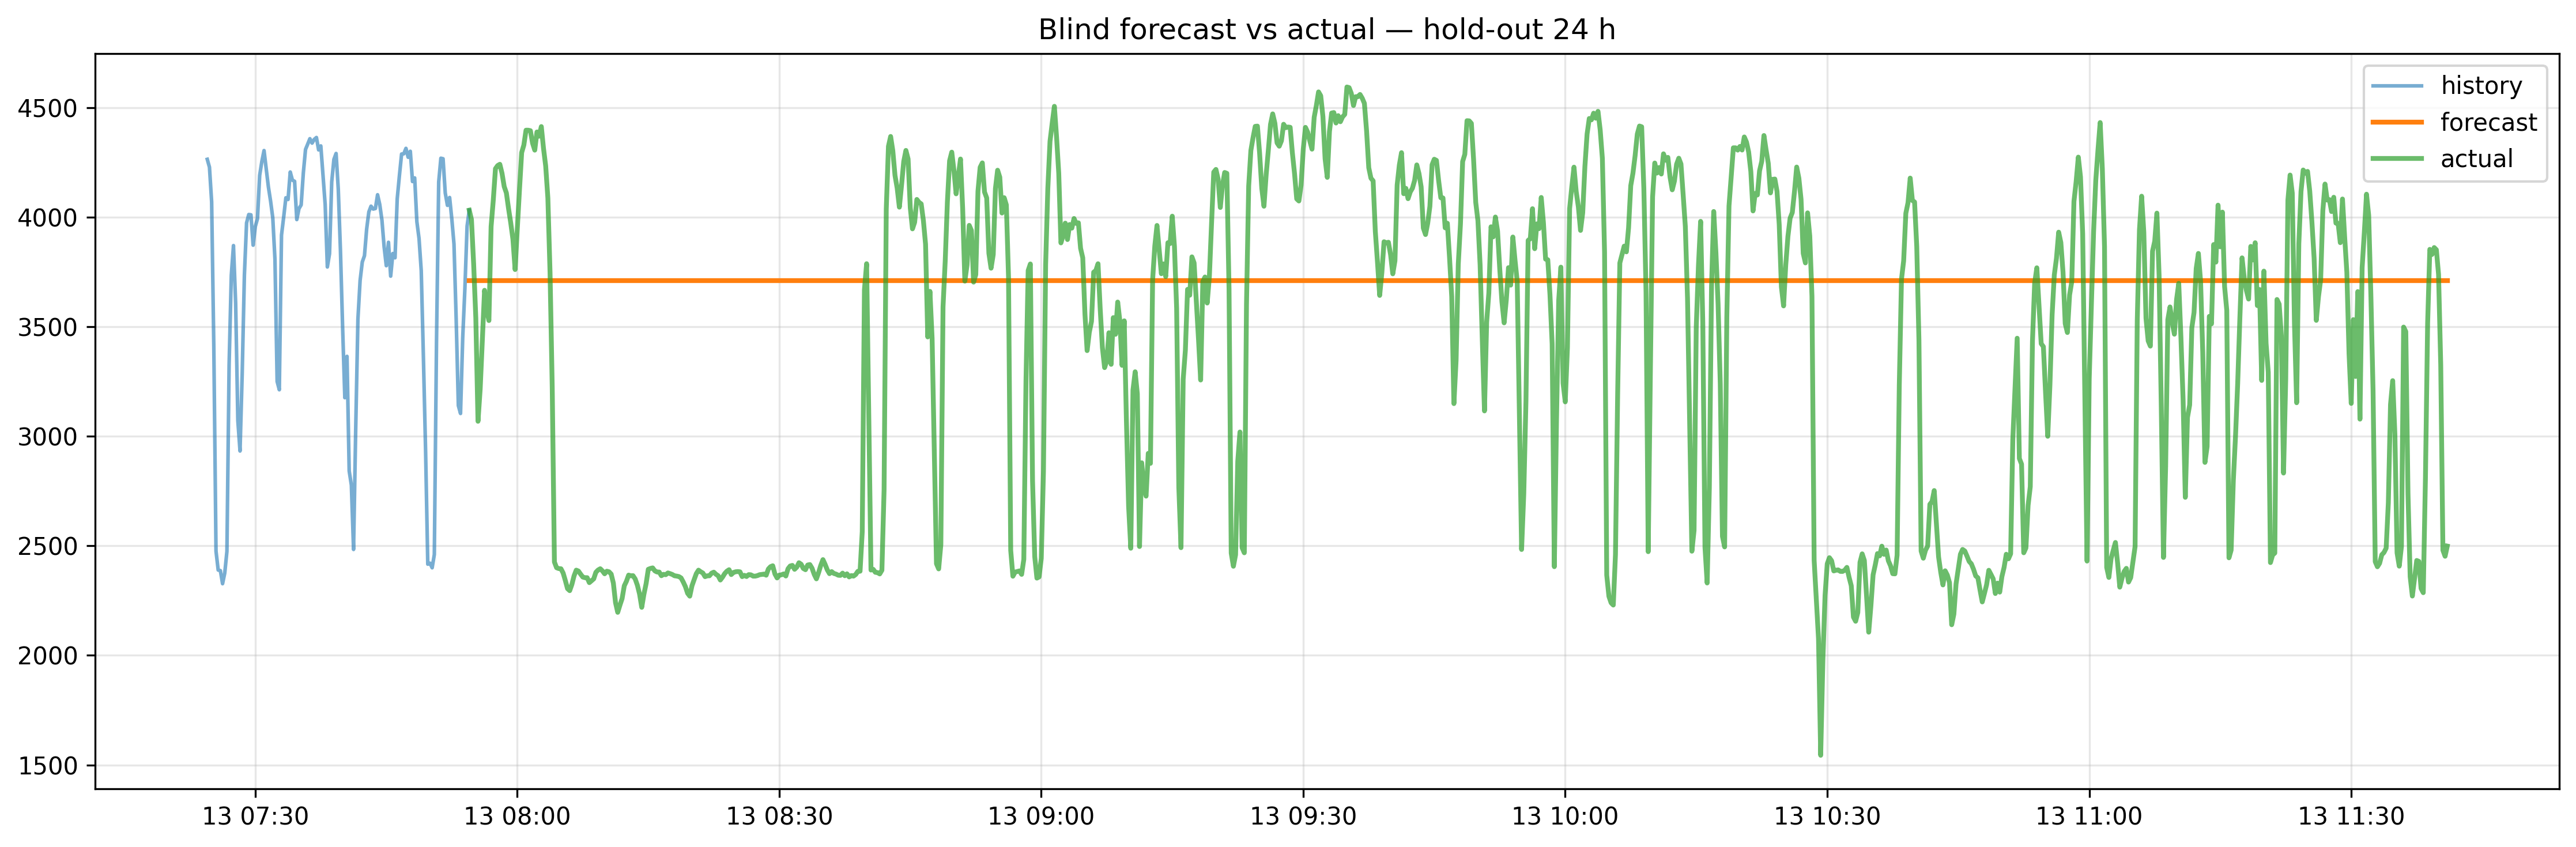

In [22]:
# y_true и y_pred уже созданы в предыдущей ячейке

metrics = global_metrics(y_true, list_of_avg_last_15_minutes_elements)
print(f"Blind 24-h test • MAE={metrics['MAE']:.1f}  RMSE={metrics['RMSE']:.1f}  MAPE={metrics['MAPE']:.2f}%  "
      f"on {len(y_true)} valid points")

# ── график: история 3 сут + прогноз vs факт ──
# hist_start = pred_idx[0] - pd.Timedelta(hours=1)
hist_start = pred_idx[0] - pd.Timedelta(minutes=30)
plot_history_forecast(
    history  = df.loc[hist_start:pred_idx[0], 'common_delay_p90'],
    forecast = pd.Series(list_of_avg_last_15_minutes_elements, index=pred_idx),
    actual   = y_true,
    title    = 'Blind forecast vs actual — hold-out 24 h'
)

## 2. Код-шаблоны для подробного анализа



*** Hold-out metrics ***
            value
MAE   1326.717233
RMSE  1539.279202
MAPE    35.785539

MAE by day:
        index          MAE
0  2025-05-13  1326.717233


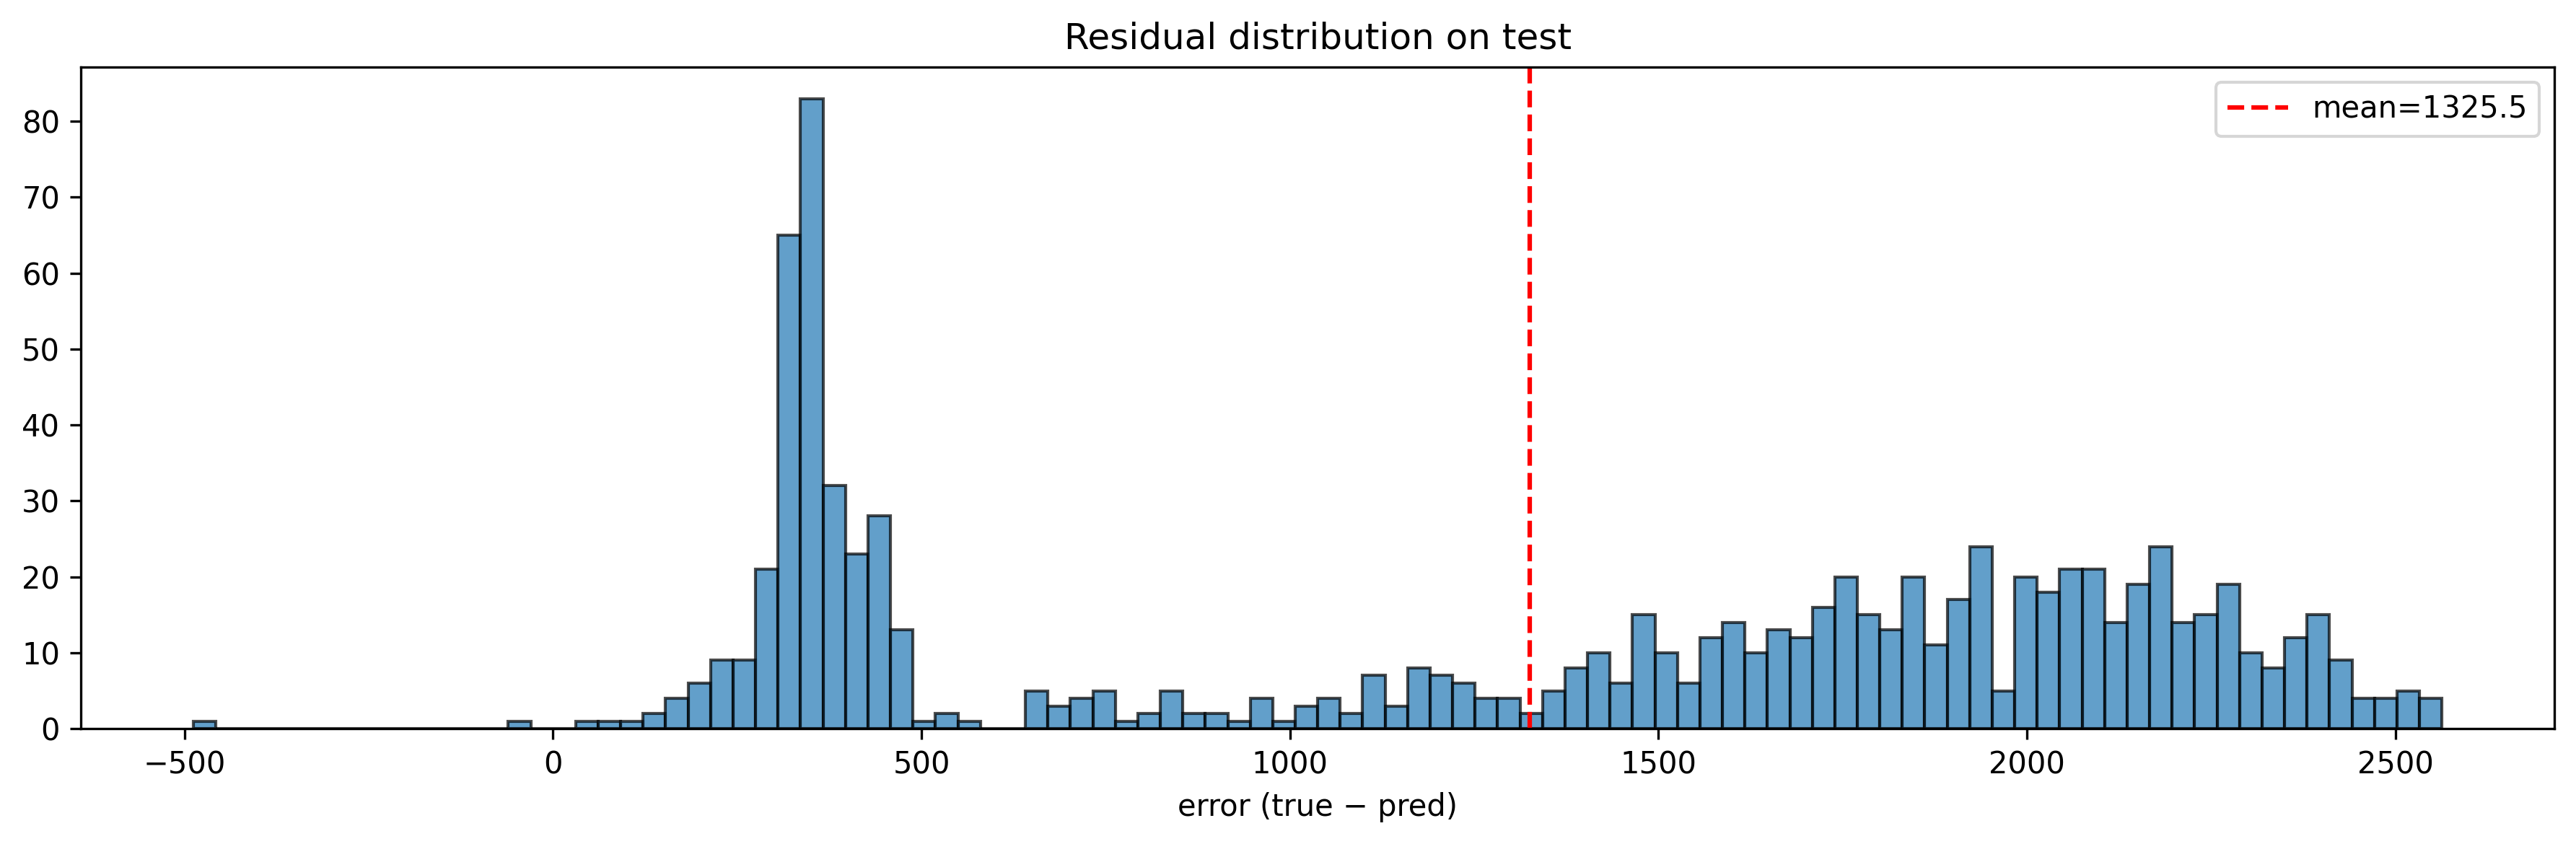

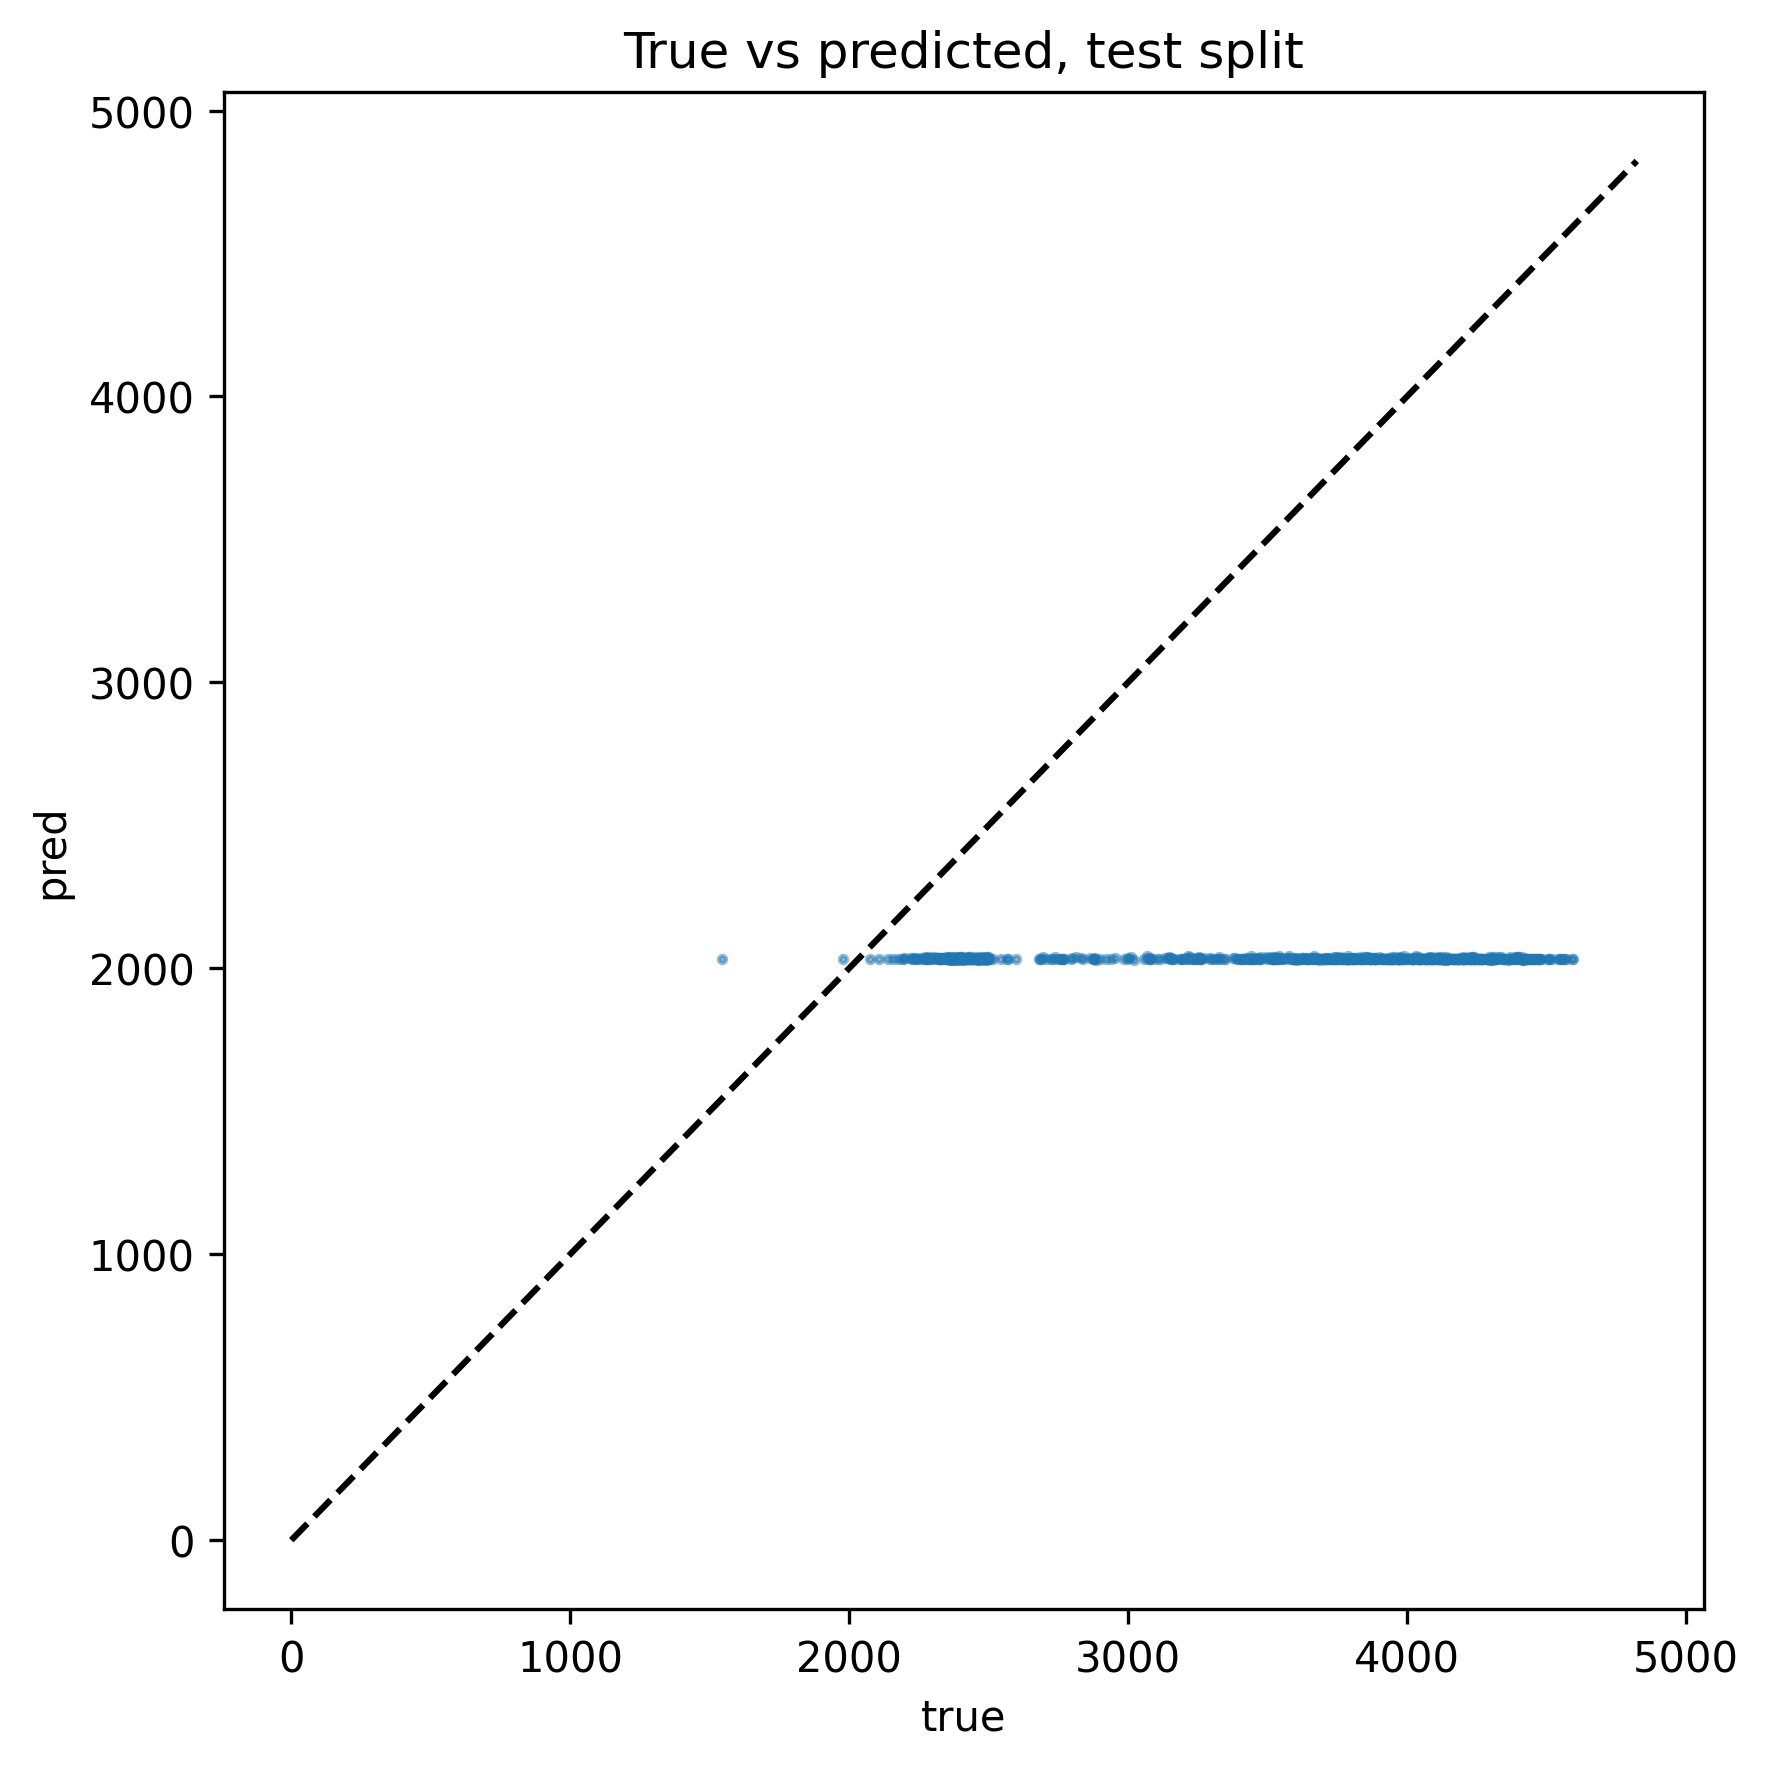

In [23]:
resid = y_true - y_pred


# ---------------------------------------------------
# 2.2  сводные метрики
# ---------------------------------------------------
metrics = global_metrics(y_true, y_pred)
metrics_df = pd.DataFrame([metrics]).T.rename(columns={0: "value"})
print("\n*** Hold-out metrics ***")
print(metrics_df)

# ---------------------------------------------------
# 2.3  метрики по суткам
# ---------------------------------------------------
daily_mae_result = daily_mae(y_true, y_pred)
print("\nMAE by day:")
print(daily_mae_result.tail())

# ---------------------------------------------------
# 2.4  распределение ошибок
# ---------------------------------------------------
plt.figure(figsize=(12,4))
plt.hist(resid, bins=100, alpha=.7, edgecolor='black')
plt.axvline(resid.mean(), color='r', linestyle='--', label=f"mean={resid.mean():.1f}")
plt.title("Residual distribution on test")
plt.xlabel("error (true − pred)")
plt.legend(); plt.tight_layout(); plt.show()

# ---------------------------------------------------
# 2.5  true vs pred scatter
# ---------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=3, alpha=0.5)
lim = [0, max(y_true.max(), y_pred.max())*1.05]
plt.plot(lim, lim, 'k--')
plt.xlabel("true"); plt.ylabel("pred")
plt.title("True vs predicted, test split")
plt.tight_layout(); plt.show()


## 3. Feature Importance (какие лаги реально работают)

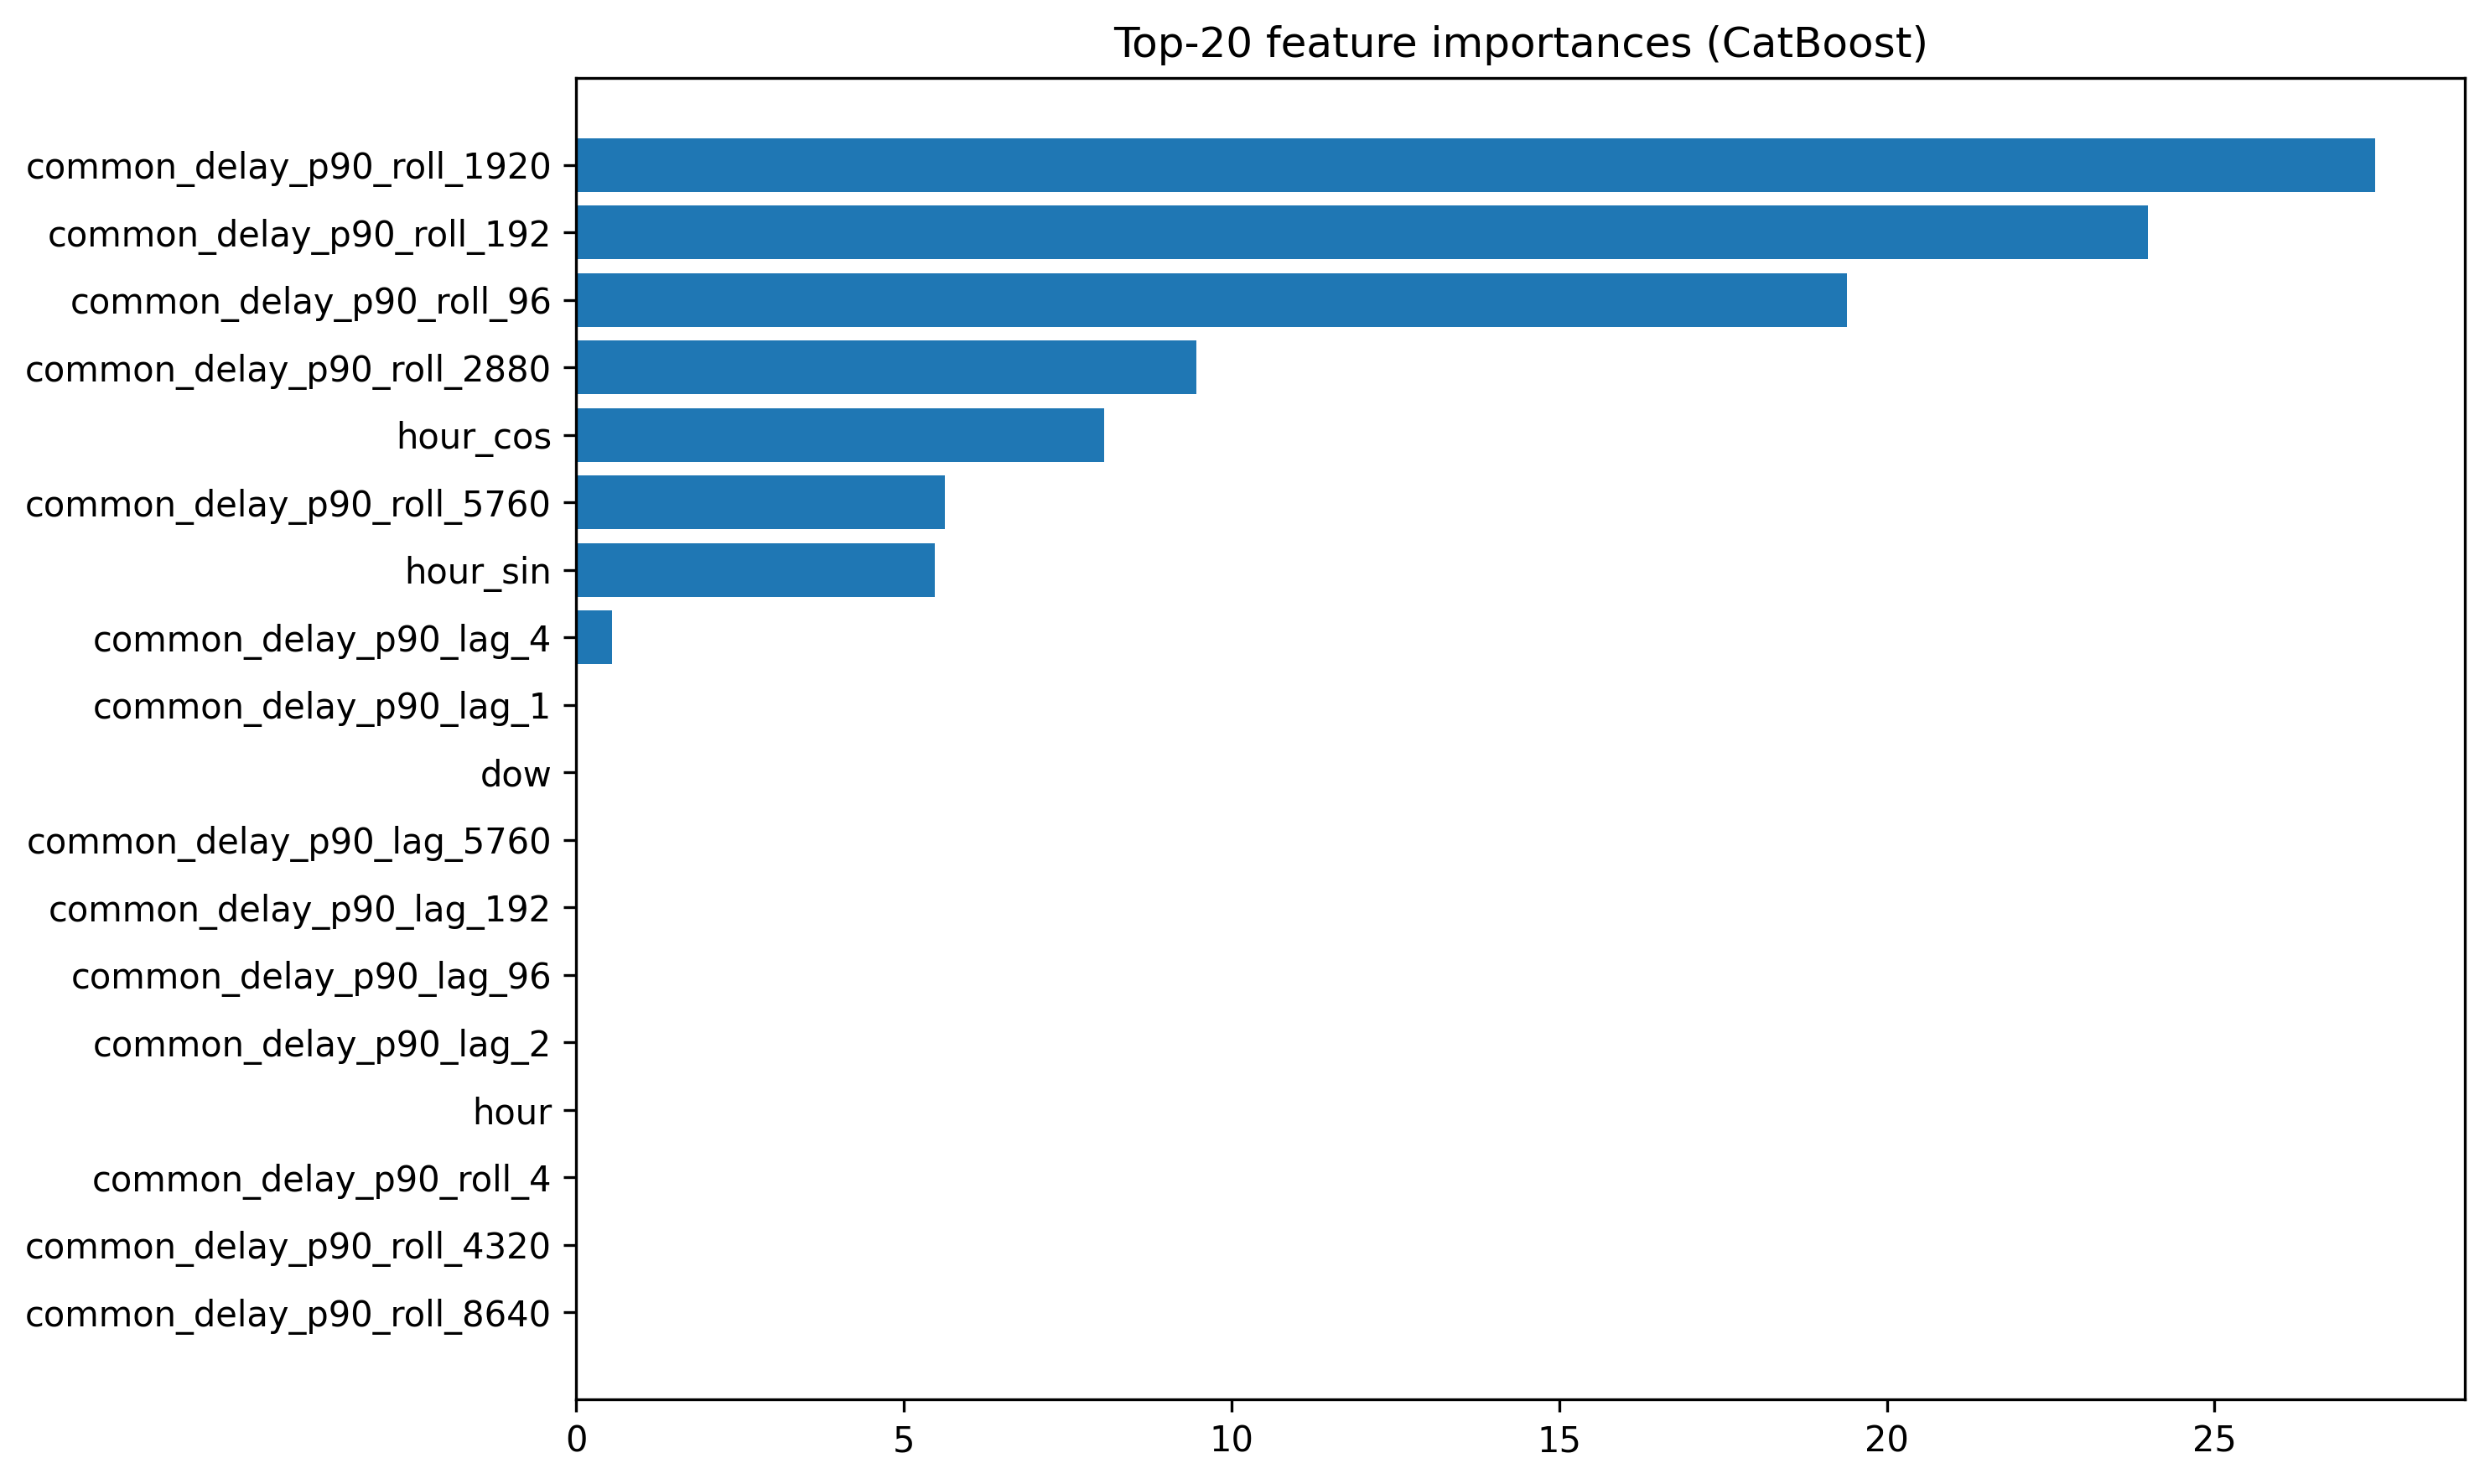

In [25]:
# model = loaded_model
feat_names = model.model.feature_names_        # ← то, что CatBoost запомнил
importances = model.model.get_feature_importance(type='FeatureImportance')

# в один датафрейм
imp_df = (pd.DataFrame({"feature": feat_names,
                        "importance": importances})
            .sort_values(by="importance", ascending=False)
            .reset_index(drop=True))

# ---------------------------------------------------
#  топ-20 на графике
# ---------------------------------------------------
plt.figure(figsize=(10,6))
plt.barh(imp_df.feature[::-1],
         imp_df.importance[::-1])
# plt.barh(imp_df.feature.head(20)[::-1],
#          imp_df.importance.head(20)[::-1])
plt.title("Top-20 feature importances (CatBoost)")
plt.tight_layout(); plt.show()


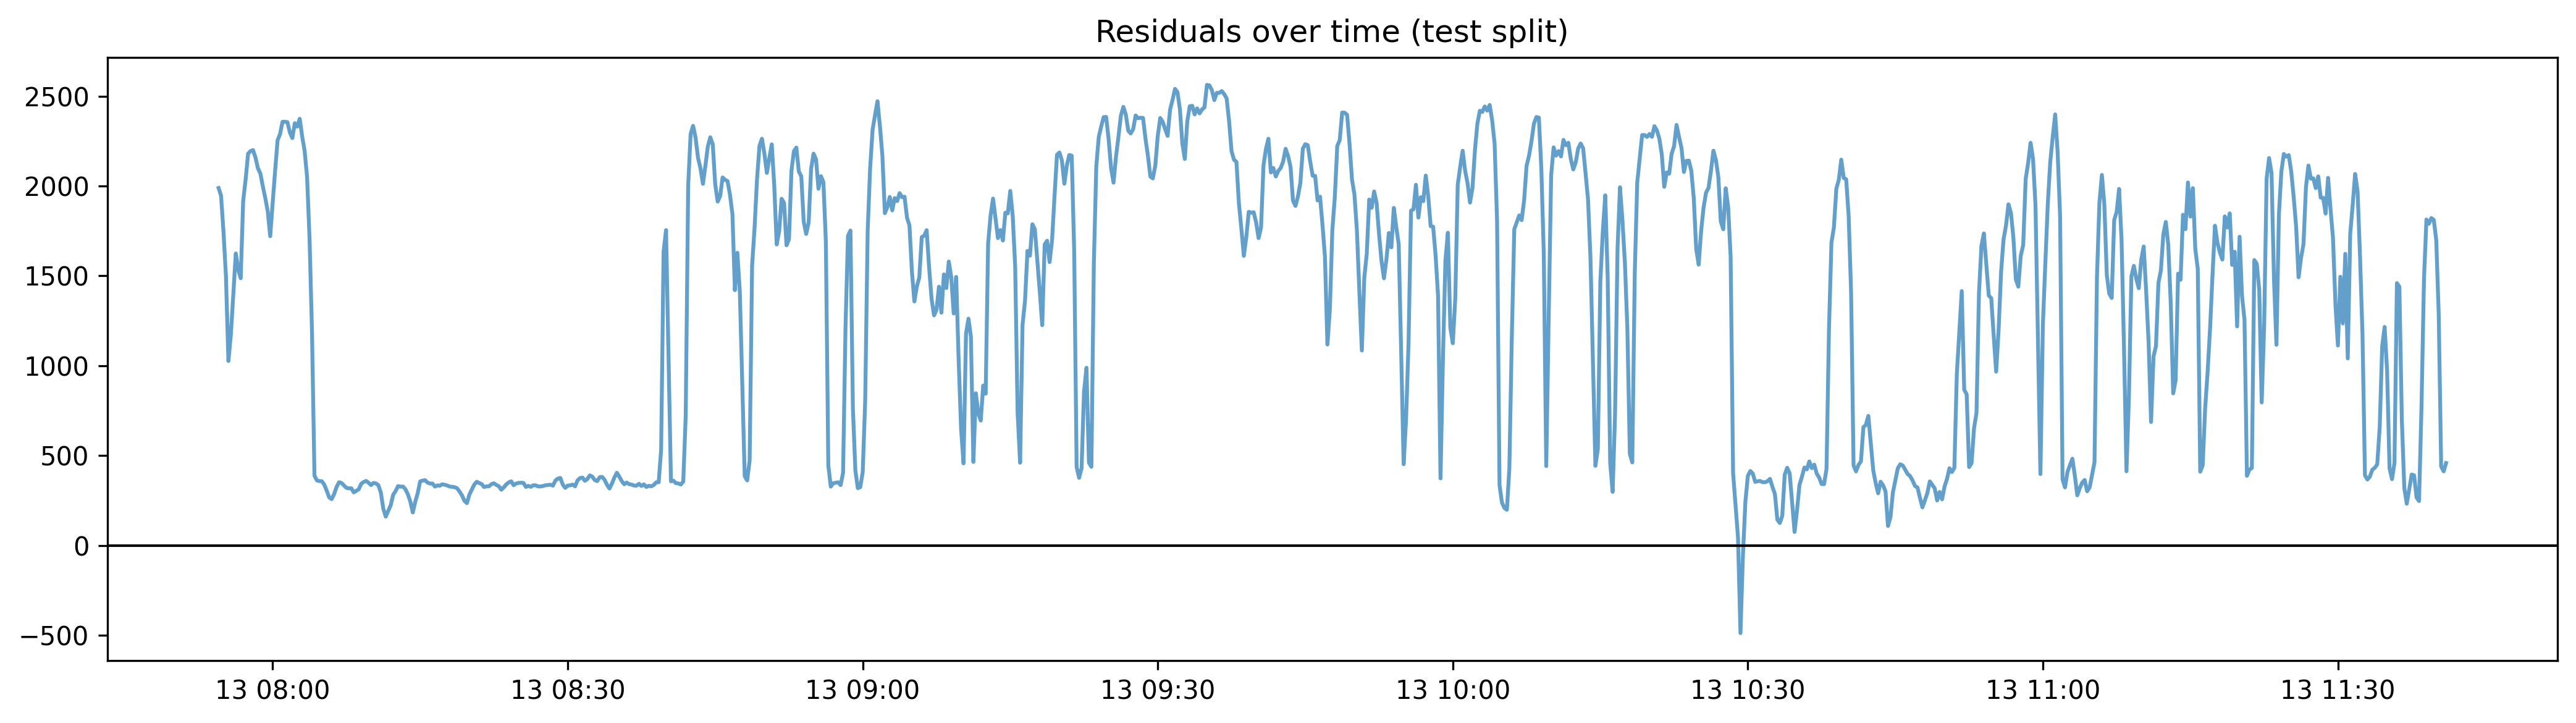

In [26]:
plt.figure(figsize=(14,4))
plt.plot(resid.index, resid, alpha=0.7)
plt.title("Residuals over time (test split)")
plt.axhline(0, color='k', lw=1)
plt.tight_layout(); plt.show()
